In [239]:
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import scipy.stats

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.patches import Ellipse

np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

# Task 1

In [274]:
def one_max_objective(samples):
    return np.sum(samples, axis=1)


def deceptive_one_max_objective(samples):
    sums = np.sum(samples, axis=1)
    sums[sums == 0] = samples.shape[1] + 1
    return sums


def k_deceptive_one_max_objective(k, samples):
    block_sums = np.array(list(map(deceptive_one_max_objective, np.split(samples, k, axis=1))))
    return np.sum(block_sums, axis=0)

def pattern_objective(pattern, samples):
    return np.sum(samples == pattern, axis=1)


def test_algorithm(name, alg_func, objective_func):
    best_sample, score_map = alg_func(objective_func)
    sorted_score_tuples = sorted(score_map.items())    
    plt.plot(list(map(lambda x: x[0], sorted_score_tuples)), list(map(lambda x: x[1], sorted_score_tuples)))
    print("Algorithm = {}, score = {}".format(name, objective_func(np.array([best_sample]))[0]))

    
test_samples = np.array([[1, 1, 1, 1], [0, 0, 0, 0], [1, 0, 1, 1], [1, 0, 0, 1], [1, 0, 0, 0]])
print(one_max_objective(test_samples))
print(deceptive_one_max_objective(test_samples))
print(k_deceptive_one_max_objective(2, test_samples))
print(pattern_objective(np.array([1, 0, 1, 1]), test_samples))

[4 0 3 2 1]
[4 5 3 2 1]
[4 6 3 2 4]
[3 1 4 3 2]


In [268]:
def random_individual(probs):
    x = np.empty(probs.shape[0])
    for i in range(probs.shape[0]):
        x[i] = np.random.choice(2, p=[1 - probs[i], probs[i]])
    return x


def random_population(probs, population_size):
    population = np.empty((population_size, probs.shape[0]))
    for i in range(population_size):
        population[i] = random_individual(probs)
    return population


def best_sample(objective_function, samples):
    return samples[np.argmax(objective_function(samples))]
    

def get_best_worst_individuals(objective_function, x1, x2):
    if objective_function(np.array([x1])) > objective_function(np.array([x2])):
        return x1, x2
    return x2, x1


def select_best_samples(objective_function, samples, best_samples_size):
    EPSILON_PROBABILITY = 1e-4
    adaptations = objective_function(samples)
    adaptations = adaptations - np.min(adaptations)
    if np.sum(adaptations) == 0:
        adaptations = np.repeat(1.0, samples.shape[0])
    adaptations[adaptations == 0] = EPSILON_PROBABILITY
    adaptations = adaptations / np.sum(adaptations)
    best_indexes = np.random.choice(samples.shape[0], best_samples_size, p=adaptations, replace=False)
    return samples[best_indexes, :]


def umda_model_estimation(samples):
    return np.average(samples, axis=0)
    

def cga(objective_function, dim_size, learning_rate, max_time):
    p = np.ones(dim_size) * 0.5
    start_time = time.time()
    score_map = {}
    while time.time() - start_time < max_time:
        x1 = random_individual(p)
        x2 = random_individual(p)
        best_individual, worst_individual = get_best_worst_individuals(objective_function, x1, x2)
        score_map[int(np.floor(time.time() - start_time))] = objective_function(np.array([best_individual]))
        for k in range(dim_size):
            if best_individual[k] == 1 and worst_individual[k] == 0:
                p[k] = min(p[k] + learning_rate, 1.0)
            elif best_individual[k] == 0 and worst_individual[k] == 1:
                p[k] = max(p[k] - learning_rate, 0.0)
    return best_sample(objective_function, np.array([random_individual(p), random_individual(p)])), score_map
                
def pbil(objective_function, dim_size, population_size, learning_rate, mutation_prob, mutation_noise, max_time):
    p = np.ones(dim_size) * 0.5
    start_time = time.time()
    score_map = {}
    while time.time() - start_time < max_time:
        samples = random_population(p, population_size)
        best_individual = best_sample(objective_function, samples)
        score_map[int(np.floor(time.time() - start_time))] = objective_function(np.array([best_individual]))
        for k in range(dim_size):
            p[k] = p[k] * (1 - learning_rate) + learning_rate * best_individual[k]
        for k in range(dim_size):
            if np.random.rand() < mutation_prob:
                p[k] = p[k] * (1 - mutation_noise) + np.random.choice(2) * mutation_noise
    return best_sample(objective_function, random_population(p, population_size)), score_map 
                
def umda(objective_function, dim_size, population_size, best_samples_size, max_time):
    p = np.ones(dim_size) * 0.5
    start_time = time.time()
    score_map = {}
    while time.time() - start_time < max_time:
        samples = random_population(p, population_size)
        best_samples = select_best_samples(objective_function, samples, best_samples_size)
        best_individual = best_sample(objective_function, best_samples)
        score_map[int(np.floor(time.time() - start_time))] = objective_function(np.array([best_individual]))        
        p = umda_model_estimation(best_samples)
    return best_sample(objective_function, random_population(p, population_size)), score_map

## One max

Algorithm = cga, score = 84.0
Algorithm = pbil, score = 96.0
Algorithm = umda, score = 100.0


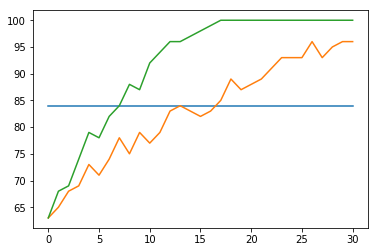

In [277]:
dim_size = 100
max_time = 30

test_algorithm('cga', lambda x: cga(x, dim_size, 0.1, max_time), one_max_objective)
test_algorithm('pbil', lambda x: pbil(x, dim_size, 200, 0.05, 0.01, 0.03, max_time), one_max_objective)
test_algorithm('umda', lambda x: umda(x, dim_size, 200, 100, max_time), one_max_objective)

## Deceptive one max

Algorithm = cga, score = 82.0
Algorithm = pbil, score = 98.0
Algorithm = umda, score = 100.0


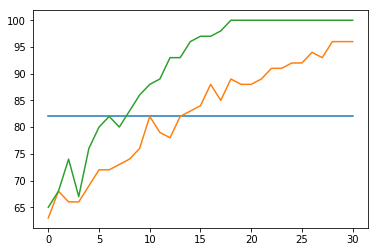

In [290]:
dim_size = 100
max_time = 30

test_algorithm('cga', lambda x: cga(x, dim_size, 0.1, max_time), deceptive_one_max_objective)
test_algorithm('pbil', lambda x: pbil(x, dim_size, 200, 0.05, 0.01, 0.03, max_time), deceptive_one_max_objective)
test_algorithm('umda', lambda x: umda(x, dim_size, 200, 100, max_time), deceptive_one_max_objective)

## K-Deceptive one max 

Algorithm = cga, score = 88.0
Algorithm = pbil, score = 116.0
Algorithm = umda, score = 105.0


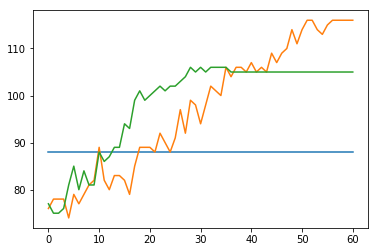

In [418]:
dim_size = 90
max_time = 60

test_algorithm('cga', lambda x: cga(x, dim_size, 0.1, max_time), lambda x: k_deceptive_one_max_objective(30, x))
test_algorithm('pbil', lambda x: pbil(x, dim_size, 200, 0.05, 0.01, 0.03, max_time),  lambda x: k_deceptive_one_max_objective(30, x))
test_algorithm('umda', lambda x: umda(x, dim_size, 200, 100, max_time),  lambda x: k_deceptive_one_max_objective(30, x))

Algorithm = cga, score = 75.0
Algorithm = pbil, score = 87.0
Algorithm = umda, score = 81.0


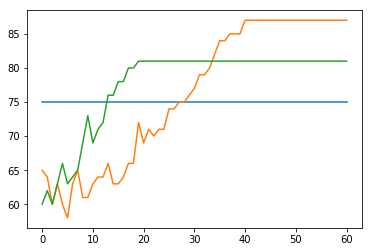

In [419]:
dim_size = 80
max_time = 60

test_algorithm('cga', lambda x: cga(x, dim_size, 0.1, max_time), lambda x: k_deceptive_one_max_objective(20, x))
test_algorithm('pbil', lambda x: pbil(x, dim_size, 200, 0.05, 0.01, 0.03, max_time),  lambda x: k_deceptive_one_max_objective(20, x))
test_algorithm('umda', lambda x: umda(x, dim_size, 200, 100, max_time),  lambda x: k_deceptive_one_max_objective(20, x))

Algorithm = cga, score = 85.0
Algorithm = pbil, score = 103.0
Algorithm = umda, score = 99.0


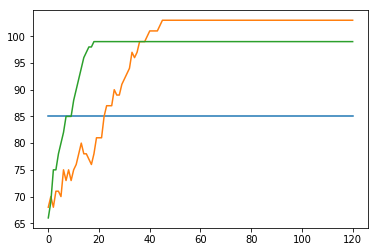

In [294]:
dim_size = 100
max_time = 120

test_algorithm('cga', lambda x: cga(x, dim_size, 0.1, max_time), lambda x: k_deceptive_one_max_objective(20, x))
test_algorithm('pbil', lambda x: pbil(x, dim_size, 200, 0.05, 0.01, 0.03, max_time),  lambda x: k_deceptive_one_max_objective(20, x))
test_algorithm('umda', lambda x: umda(x, dim_size, 200, 100, max_time),  lambda x: k_deceptive_one_max_objective(20, x))

## Pattern

Algorithm = cga, score = 82
Algorithm = pbil, score = 98
Algorithm = umda, score = 100


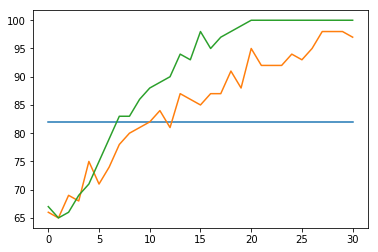

In [280]:
dim_size = 100
max_time = 30
pattern = np.zeros(dim_size)
pattern[::2] = 1

test_algorithm('cga', lambda x: cga(x, dim_size, 0.1, max_time), lambda x: pattern_objective(pattern, x))
test_algorithm('pbil', lambda x: pbil(x, dim_size, 200, 0.05, 0.01, 0.03, max_time),  lambda x: pattern_objective(pattern, x))
test_algorithm('umda', lambda x: umda(x, dim_size, 200, 100, max_time),  lambda x: pattern_objective(pattern, x))

# Task 2

In [413]:
class SampleGenerator:
    def __init__(self, samples):
        self.random_variables = self._generate_random_variables(samples)
        self.conditional_random_variables = self._generate_conditional_random_variables(samples)
        self.random_variables_permutation = self._generate_random_variables_permutation()
        
    def _generate_random_variables(self, samples):
        zero_probs = np.sum(samples == 0, axis=0) / samples.shape[0]
        return np.array([zero_probs, 1 - zero_probs]).transpose()

    def _generate_conditional_random_variables(self, samples):
        conditional_random_variables = np.empty((samples.shape[1], samples.shape[1], 2, 2))
        for i in range(samples.shape[1]):
            for j in range(samples.shape[1]):
                zero_indexes = samples[:, i] == 0
                if np.sum(zero_indexes) == 0:
                    zero_prob = 0.5
                else:
                    zero_prob = np.sum(samples[zero_indexes, j] == 0) / np.sum(zero_indexes)                    
                non_zero_indexes = samples[:, i] != 0
                if np.sum(non_zero_indexes) == 0:
                    non_zero_prob = 0.5
                else:
                    non_zero_prob = np.sum(samples[non_zero_indexes, j] == 0) / np.sum(non_zero_indexes)
                conditional_random_variables[i, j] = [[zero_prob, 1 - zero_prob], [non_zero_prob, 1 - non_zero_prob]]
        return conditional_random_variables
    
    def _get_entropies(self):
        entropies = np.empty((self.random_variables.shape[0], self.random_variables.shape[0]))
        for i in range(self.random_variables.shape[0]):
            for j in range(self.random_variables.shape[0]):
                if i == j:
                    entropies[i, j] = scipy.stats.entropy(self.random_variables[i])
                else:                    
                    entropies[i, j] = scipy.stats.entropy(self.random_variables[i], self.random_variables[j])        
        return entropies
    
    def _generate_random_variables_permutation(self):
        variables_count = self.random_variables.shape[0]
        random_variables_permutation = np.empty(variables_count, dtype=np.int32)        
        entropies = self._get_entropies()
        diagonal_entropies = entropies[np.arange(variables_count), np.arange(variables_count)]
        random_variables_permutation[variables_count - 1] = np.argmin(diagonal_entropies)
        free_variable_idxs = set(range(variables_count))
        free_variable_idxs.remove(random_variables_permutation[variables_count - 1])
        for i in range(variables_count - 2, -1, -1):
            prev_variable_idx = random_variables_permutation[i + 1]
            indexes_order = list(free_variable_idxs)
            random_variables_permutation[i] = indexes_order[np.argmin(entropies[indexes_order, prev_variable_idx])]
            free_variable_idxs.remove(random_variables_permutation[i])
        return random_variables_permutation
                
    def generate_samples(self, count):
        variables_count = self.random_variables.shape[0]
        samples = np.empty((count, variables_count), dtype=np.int32)
        init_rv_idx = self.random_variables_permutation[variables_count - 1]
        samples[:, init_rv_idx] = np.random.choice(2, count, p=self.random_variables[init_rv_idx])
        for i in range(variables_count - 2, -1, -1):
            rv_idx, prev_rv_idx = self.random_variables_permutation[i:(i + 2)]
            prev_rv_choices = samples[:, prev_rv_idx]
            probs = self.conditional_random_variables[prev_rv_idx, rv_idx, prev_rv_choices]
            for j in range(count):
                samples[j, rv_idx] = np.random.choice(2, p=probs[j])
        return samples
    
def mimic(objective_function, dim_size, population_size, best_samples_size, max_time, debug_mode=False):
    start_time = time.time()
    score_map = {}
    samples = random_population(np.repeat(0.5, dim_size), population_size)
    while time.time() - start_time < max_time:
        best_samples = samples[np.argsort(-objective_function(samples))[:best_samples_size], :]        
        sample_generator = SampleGenerator(best_samples)
        samples = sample_generator.generate_samples(population_size)
        best_individual = best_sample(objective_function, samples)
        best_score = objective_function(np.array([best_individual]))
        score_map[int(np.floor(time.time() - start_time))] = best_score
        if debug_mode:
            print("Score = %.2f" % (best_score))
    return best_sample(objective_function, samples), score_map

#a = np.array([[0, 0, 1], [1, 0, 1], [1, 1, 0], [1, 0, 0]])
#b = np.copy(a[:, 0])
#a[:, 0] = a[:, 1]
#a[:, 1] = b
#x = SampleGenerator(a)
#x.generate_samples(10)

## One max

Algorithm = mimic, score = 100


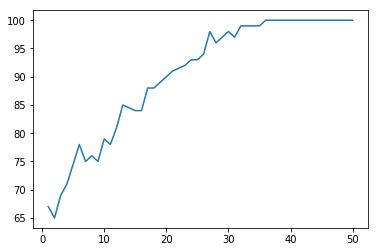

In [389]:
dim_size = 100
max_time = 50

test_algorithm('mimic', lambda x: mimic(x, dim_size, 200, 160, max_time), one_max_objective)

## Deceptive one max

Algorithm = mimic, score = 100


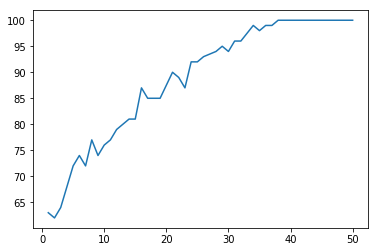

In [390]:
test_algorithm('mimic', lambda x: mimic(x, dim_size, 200, 160, max_time), deceptive_one_max_objective)

## K-Deceptive one max 

Algorithm = mimic, score = 116


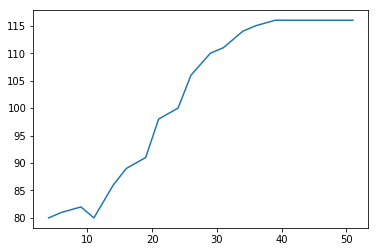

In [414]:
dim_size = 90
max_time = 50

test_algorithm('mimic', lambda x: mimic(x, dim_size, 1000, 100, max_time),  lambda x: k_deceptive_one_max_objective(30, x))

Algorithm = mimic, score = 90


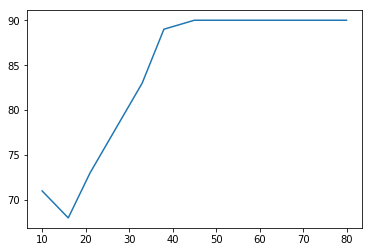

In [442]:
dim_size = 80
max_time = 80

test_algorithm('mimic', lambda x: mimic(x, dim_size, 3000, 30, max_time),  lambda x: k_deceptive_one_max_objective(20, x))

Algorithm = mimic, score = 103


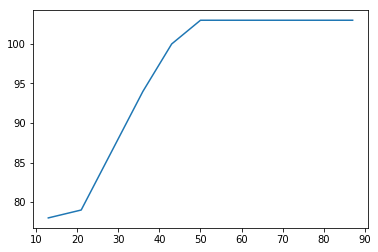

In [439]:
dim_size = 100
max_time = 80

test_algorithm('mimic', lambda x: mimic(x, dim_size, 3000, 30, max_time),  lambda x: k_deceptive_one_max_objective(20, x))

## Pattern

Algorithm = mimic, score = 100


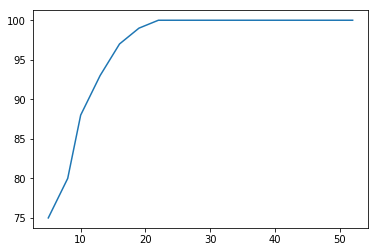

In [417]:
dim_size = 100
max_time = 50

test_algorithm('mimic', lambda x: mimic(x, dim_size, 1000, 100, max_time),  lambda x: pattern_objective(pattern, x))

# Task 3

In [69]:
def fast_non_dominated_sort(f1_values, f2_values):
    samples_count = f1_values.shape[0]
    dominant_count = {i: 0 for i in range(samples_count)}
    dominated_set = {i: set() for i in range(samples_count)}
    for i in range(samples_count):
        for j in range(i):
            if f1_values[i] == f1_values[j] and f2_values[i] == f2_values[j]:
                continue
            if f1_values[i] <= f1_values[j] and f2_values[i] <= f2_values[j]:
                dominant_count[j] += 1
                dominated_set[i].add(j)
            elif f1_values[i] >= f1_values[j] and f2_values[i] >= f2_values[j]:
                dominant_count[i] += 1
                dominated_set[j].add(i)
    dominant_batches = []
    while len(dominant_count) > 0:
        zero_indexes = list(filter(lambda x: dominant_count[x] == 0, dominant_count))
        dominant_batches.append(set(zero_indexes))
        for zero_index in zero_indexes:
            del dominant_count[zero_index]
            for dominated_index in dominated_set[zero_index]:
                dominant_count[dominated_index] -= 1            
    return dominant_batches
    
print(fast_non_dominated_sort(np.array([1, 2, 3]), np.array([6, 5, 4])))
print(fast_non_dominated_sort(np.array([1, 2, 3, 4, 5, 6, 7]), np.array([2, 1, 4, 3, 7, 6, 5])))

[{0, 1, 2}]
[{0, 1}, {2, 3}, {4, 5, 6}]


In [148]:
def get_crowding_distances(f1_values, f2_values):
    samples_count = f1_values.shape[0]
    crowding_distances = [0 for i in range(samples_count)]
    sorted_f1_args = np.argsort(f1_values)
    sorted_f2_args = np.argsort(f2_values)
    for i in range(1, samples_count - 1):
        prev_f1_arg, cur_f1_arg, next_f1_arg = sorted_f1_args[i - 1:i + 2] 
        prev_f2_arg, cur_f2_arg, next_f2_arg = sorted_f2_args[i - 1:i + 2]
        f1_dist = (f1_values[next_f1_arg] - f1_values[prev_f1_arg]) / (max(f1_values) - min(f1_values))
        f2_dist = (f2_values[next_f2_arg] - f2_values[prev_f2_arg]) / (max(f2_values) - min(f2_values))
        crowding_distances[cur_f1_arg] += f1_dist
        crowding_distances[cur_f2_arg] += f2_dist
    crowding_distances[sorted_f1_args[0]] = np.inf
    crowding_distances[sorted_f1_args[samples_count - 1]] = np.inf
    crowding_distances[sorted_f2_args[0]] = np.inf    
    crowding_distances[sorted_f2_args[samples_count - 1]] = np.inf        
    return np.array(crowding_distances)
    
print(get_crowding_distances(np.array([1, 2, 5, 3, 10, 3, 20]), np.array([10, 15, 7, 11, 1, 20, 21])))

[       inf 0.55526316 0.81842105 0.30263158        inf 0.40526316
        inf]


In [223]:
def crossover(parent1, parent2, crossover_prob):
    if np.random.rand() <= crossover_prob:
        gen_intersection_point = np.random.choice(parent1.shape[0])
        child1 = np.hstack([parent1[:gen_intersection_point], parent2[gen_intersection_point:]])
        child2 = np.hstack([parent2[:gen_intersection_point], parent1[gen_intersection_point:]])
        return child1, child2
    return parent1.copy(), parent2.copy()

def mutate_randomly(sample, min_val, max_val, mutation_prob, mutation_radius):
    for i in range(sample.shape[0]):
        if np.random.rand() <= mutation_prob:
            sample[i] += np.random.randn() * (max_val - min_val) * mutation_radius
            sample[i] = max(sample[i], min_val)
            sample[i] = min(sample[i], max_val)
            
def make_new_population(samples, min_val, max_val, crossover_prob, mutation_prob, mutation_radius):
    children = []
    samples = samples[np.random.permutation(samples.shape[0])]
    for i in range(0, samples.shape[0], 2):
        child1, child2 = crossover(samples[i], samples[i + 1], crossover_prob)
        mutate_randomly(child1, min_val, max_val, mutation_prob, mutation_radius)
        mutate_randomly(child2, min_val, max_val, mutation_prob, mutation_radius)
        children.extend([child1, child2])
    return np.array(children)

print(crossover(np.array([1, 2, 3, 4]), np.array([5, 6, 7, 8]), 0.75))
x = np.array([1, 2, 3, 8, 9, 10])
mutate_randomly(x, 2, 10, 0.2, 0.01)
print(x)
print(make_new_population(np.array([[1, 2, 3, 4], [5, 6, 7, 8]]), 2, 10, 0.8, 0.2, 0.01))

(array([1, 2, 3, 4]), array([5, 6, 7, 8]))
[ 2  2  3  8  9 10]
[[5 6 7 4]
 [2 2 3 8]]


In [225]:
def nsga2(objective_function, population_size, chromosom_length, min_val, max_val, crossover_prob, mutation_prob, 
          iter_count, mutation_radius=0.01):
    population = min_val + (max_val - min_val) * np.random.rand(population_size, chromosom_length)
    for i in range(iter_count):
        selected_samples = []
        f1_values, f2_values = objective_function(population)
        dominant_batches = fast_non_dominated_sort(f1_values, f2_values)
        batch_number = 0
        while batch_number < len(dominant_batches) and len(selected_samples) + len(dominant_batches[batch_number]) <= population_size:
            selected_samples.extend(population[list(dominant_batches[batch_number])])
            batch_number += 1
        if population_size - len(selected_samples) > 0:
            batch_indexes = np.array(list(dominant_batches[batch_number]), dtype=np.int32)  
            crowding_distances = get_crowding_distances(f1_values[batch_indexes], f2_values[batch_indexes])
            sliced_indexes = list(reversed(np.argsort(crowding_distances)))
            crowding_indexes = np.array(sliced_indexes, dtype=np.int32)[:(population_size - len(selected_samples))]
            selected_samples.extend(population[batch_indexes[crowding_indexes]])  
        children = make_new_population(np.array(selected_samples), min_val, max_val, crossover_prob, mutation_prob, mutation_radius)
        population = np.unique(np.vstack([selected_samples, children]), axis=0)
    dominant_batches = fast_non_dominated_sort(*objective_function(population))
    return population[list(dominant_batches[0])]

# Task 4

In [146]:
def sch_objective(samples):
    return ((samples ** 2).reshape(-1), ((samples - 2) ** 2).reshape(-1))

def fon_objective(samples):
    f1 = 1 - np.exp(-np.sum((samples - 1 / np.sqrt(3)) ** 2, axis=1))
    f2 = 1 - np.exp(-np.sum((samples + 1 / np.sqrt(3)) ** 2, axis=1))
    return (f1, f2)

def zdt1_objective(samples):
    f1 = samples[:, 0]
    g = 1 + 9 * (np.sum(samples[:, 1:], axis=1)) / 29
    f2 = g * (1 - np.sqrt(samples[:, 0] / g)) 
    return (f1, f2)
    
def zdt2_objective(samples):
    f1 = samples[:, 0]
    g = 1 + 9 * (np.sum(samples[:, 1:], axis=1)) / 29
    f2 = g * (1 - (samples[:, 0] / g) ** 2) 
    return (f1, f2)

def zdt3_objective(samples):
    f1 = samples[:, 0]
    g = 1 + 9 * (np.sum(samples[:, 1:], axis=1)) / 29
    f2 = g * (1 - np.sqrt(samples[:, 0] / g - samples[:, 0] / g * np.sin(10 * np.pi * samples[:, 0]))) 
    return (f1, f2)

print(sch_objective(np.array([[1, 2, 3]])))    
print(fon_objective(np.array([[0.3, 0.3, 0.4], [-0.577, -0.577, -0.577]])))
print(zdt1_objective(np.array([np.ones(30), np.ones(30) * 2])))
print(zdt2_objective(np.array([np.ones(30), np.ones(30) * 2])))
print(zdt3_objective(np.array([np.ones(30), np.ones(30) * 0.15])))

(array([1, 4, 9]), array([1, 0, 1]))
(array([0.16914456, 0.98163987]), array([9.17478840e-01, 3.68065448e-07]))
(array([1., 2.]), array([ 6.83772234, 12.835586  ]))
(array([1., 2.]), array([ 9.9       , 18.78947368]))
(array([1.  , 0.15]), array([6.83772234, 1.51035722]))


## SCH

In [211]:
nsga2(sch_objective, 200, 1, -1000, 1000, 0.9, 0.2, 50)

array([[1.14289152],
       [1.18780346],
       [1.2315064 ],
       [1.27083102],
       [1.27557806],
       [1.27795594],
       [1.27900332],
       [1.29854935],
       [1.36679769],
       [1.40693504],
       [1.44753667],
       [1.46072221],
       [1.47974391],
       [1.53252944],
       [1.55015958],
       [1.55147731],
       [1.55791183],
       [1.58182079],
       [1.59493923],
       [1.61656183],
       [1.65693065],
       [1.66894956],
       [1.69729341],
       [1.89685491],
       [1.90199152],
       [1.91138222],
       [1.95581282],
       [1.96868888],
       [1.97999962],
       [1.9924298 ],
       [0.00720338],
       [0.02027927],
       [0.07002285],
       [0.07919463],
       [0.34926501],
       [0.35975889],
       [0.39110673],
       [0.40308474],
       [0.4074156 ],
       [0.42886267],
       [0.45467721],
       [0.46599559],
       [0.50364752],
       [0.54005018],
       [0.56119822],
       [0.77561971],
       [0.77826318],
       [0.810

## FON

In [245]:
nsga2(fon_objective, 500, 3, -4, 4, 0.9, 0.01, 300, 0.01)

array([[-0.57873587, -0.51291777, -0.54027127],
       [-0.55352132, -0.48221013, -0.54027127],
       [-0.53805191, -0.55959706, -0.54027127],
       [-0.53805191, -0.51291777, -0.54027127],
       [-0.53805191, -0.48221013, -0.54027127],
       [-0.49763457, -0.51291777, -0.47846758],
       [-0.49763457, -0.49610776, -0.54027127],
       [-0.49763457, -0.49610776, -0.47846758],
       [-0.49763457, -0.48221013, -0.54027127],
       [-0.4585068 , -0.49610776, -0.43655509],
       [-0.4585068 , -0.48221013, -0.47846758],
       [-0.4585068 , -0.48221013, -0.46213063],
       [-0.4585068 , -0.4365479 , -0.47846758],
       [-0.4585068 , -0.4365479 , -0.46213063],
       [-0.4585068 , -0.42710358, -0.43655509],
       [-0.45805901, -0.53176012, -0.47846758],
       [-0.45805901, -0.51291777, -0.47846758],
       [-0.45805901, -0.49610776, -0.47846758],
       [-0.45805901, -0.48221013, -0.42322483],
       [-0.45017788, -0.41562974, -0.42708069],
       [-0.4117089 , -0.48221013, -0.462

## ZDT1

In [241]:
print(nsga2(zdt1_objective, 200, 30, 0, 1, 0.9, 0.01, 300, 0.05))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.00350272 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.00406758 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.00490403 0.         0.         0.         0.         0.
  0.         

## ZDT2

In [242]:
print(nsga2(zdt2_objective, 200, 30, 0, 1, 0.9, 0.01, 300, 0.05))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.02079299 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.02120141 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.04310342 0.         0.         0.         0.         0.
  0.         

## ZDT3

In [243]:
print(nsga2(zdt3_objective, 200, 30, 0, 1, 0.9, 0.01, 300, 0.05))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.00266242 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.00361337 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.01275062 0.         0.         0.         0.         0.
  0.         